# Calibration of the Sr/Ca paleothermometer: A Bayesian approach

## Authors

[Deborah Khider](https://orcid.org/0000-0001-7501-8430)

## Preamble
 In a [previous notebook](FrequentistCalibration.ipynb), we performed the regression using various flavors of least squares. This notebook approaches the same task using Bayesian statistics, for which a good introduction is given [here](https://seeing-theory.brown.edu/bayesian-inference/index.html#section2). 

The goal of Bayesian linear regression is the same as its frequentist counterpart, which is to infer the parameters of the regression equation (i.e., the slope and intercept) that best fits the data. The main difference between the two is that Bayesian regression tries to infer the (posterior) distribution of the parameters, given some _a priori_ notions and the data. This is in contrast to the frequentist approach, which makes often strong assumptions so it can derive best estimates for these parameters, occasionally with a measure of uncertainty, using only the data.  A good introduction on Bayesian Linear Regression is available in this [Medium blog post](https://medium.com/intuition/gentle-introduction-of-bayesian-linear-regression-c83da6b0d1f7).


To perform the regression on the coral data from Delong et al. (2011), we will be using the [PyMC package](https://www.pymc.io/welcome.html). The following is adapted from the [example provided with package](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear). 

Let's also import some necessary packages along with PyMC:

In [2]:
#Some config magic first
import pytensor
pytensor.config.mode='NUMBA'
pytensor.config.cxx=""

# Necessary tool for the Bayesian calibration and visualization
import arviz as az
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import xarray as xr
import statsmodels.api as sm

from pymc import HalfCauchy, Model, Normal, sample, Uniform

# Packages to handle paleoclimate data
import pyleoclim as pyleo
from pylipd.lipd import LiPD

# Package to make publication-ready tables
from great_tables import GT, md, html

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Loading the data

For this calibration exercise, we will be using the Sr/Ca data from [DeLong et al. (2011)](https://www.sciencedirect.com/science/article/pii/S0031018211002501?casa_token=u1x_ZYnm_mIAAAAA:rU7n-8jHh2g5UPgGHs5h1iptBXVa6rfvKFxpOwgMjHgB6g4jUZ9oRppzJz7O5UQHDlc1U3xhYSg).

Lets's import it into our workspace using [pandas](https://pandas.pydata.org).

In [3]:
url = 'https://www.ncei.noaa.gov/pub/data/paleo/coral/atlantic/tortugas2011.xls'
df = pd.read_excel(url, sheet_name=1,header=[2])
df.head()

,Year,Mean Sr/Ca (mmol/mol),Number of samples,St. error of mean,Mean Sr/Ca (mmol/mol).1,Number of samples.1,St. error of mean.1,Mean Sr/Ca (mmol/mol).2,Number of samples.2,St. error of mean.2,DRTO SST (ºC),St. error of mean.3,Sand Key SST (ºC),St. error of mean.4
0,2008.625000,8.737095,1,0.012000,NaN,NaN,NaN,9.025385,3,0.003027,30.193011,0.010330,NaN,NaN
1,2008.541667,8.770223,2,0.003228,NaN,NaN,NaN,9.051444,3,0.010060,29.551197,0.010570,NaN,NaN
2,2008.458333,8.841024,2,0.003956,NaN,NaN,NaN,9.111843,3,0.000554,28.539499,0.022829,NaN,NaN
3,2008.375000,8.940933,2,0.001614,8.972382,1.0,0.01,9.190204,3,0.021459,26.642473,0.026493,NaN,NaN
4,2008.291667,9.022715,2,0.003125,9.062088,1.0,0.01,9.232626,3,0.010278,24.905000,0.019899,NaN,NaN


## *Siderastrea sidera* - core A1
### Estimating the model
For ease, let's store the data into two variables `x` and `y`. `y` contains the Sr/Ca data for core A1. `x` is the Sand Key data. For purpose of demonstration for the Bayesian regression, we will only use the Sand Key data.

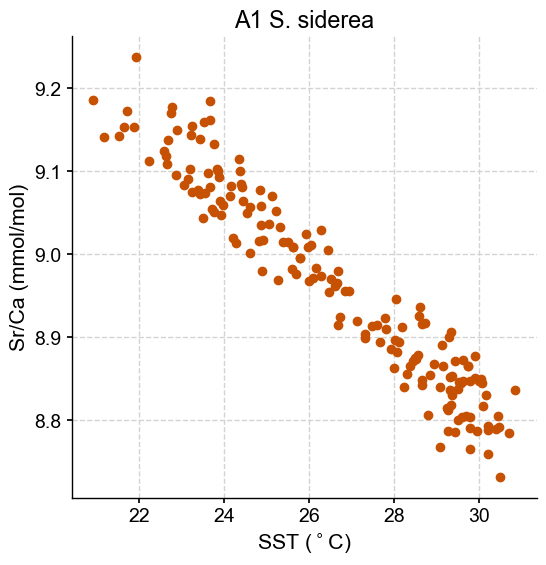

In [4]:
cleaned_df = df.dropna(subset=['Mean Sr/Ca (mmol/mol)','Sand Key SST (ºC)']) #Remove NaNs

y = cleaned_df.iloc[:,1]
x = cleaned_df.iloc[:,12]

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(x,y,marker= 'o', color = sns.xkcd_rgb['dark orange'])
ax.set_title('A1 S. siderea')
ax.set_xlabel('SST ($^\circ$C)')
ax.set_ylabel('Sr/Ca (mmol/mol)')
plt.show()

Let's fit a Bayesian linear regression to the *Siderastrea sidera* - core A1 data. In PyMC, the model specifications takes place with a `with` epxression, called a context manager. By default, PyMC uses a [NUTS sampler](http://arxiv.org/abs/1111.4246) to fit the model, resulting in a trace of samples representing the posterior distributions of the parameters.

In the Bayesian framework, we first need to define prior distributions for the slope and intercept as well as the expected error of the model. Let's first assume that we don't know much about the relationship between Sr/Ca and temperature, except for the fact that it is negative (which we infer from a simple plot from our [data exploration](DataExploration.ipynb) work). To represent this poor prior knowledge, we can use a uniform distribution with an upper limit of 0. The plot also suggests a total Sr/Ca change of -0.5mmol/mol for 10°C of temperature, which gives an average slope of -0.05 mmol/mol/°C. Let's double this for the lower limit of the uniform distribution. 

To set the prior for the intercept, we can also use a non-informative, uniform prior. The same figure places the y-intercept around 10mmol/mol. Let's use a range between 5 and 15 as boundaries for the uniform distribution:

In [5]:
with Model() as model:
    
    # Prior is a uniform distribution over the -1 to 0 interval for the slope and 0 to 50 for intercept
    slope = Uniform('Slope',lower=-0.1, upper=0)
    intercept = Uniform('Intercept',lower=5, upper=15)
    sigma = HalfCauchy("sigma", beta=10)
    
    #Define the likelihood 
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)
    #inference with 3000 samples, tuning on the first 1000 with 4 chains   
    idata = sample(draws=3000, chains = 4, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 7 seconds.


### Analyzing the model

Bayesian inference gives us a posterior distribution of plausible parameters. Let's plot the posterior distribution of our parameters and the individual samples we drew:

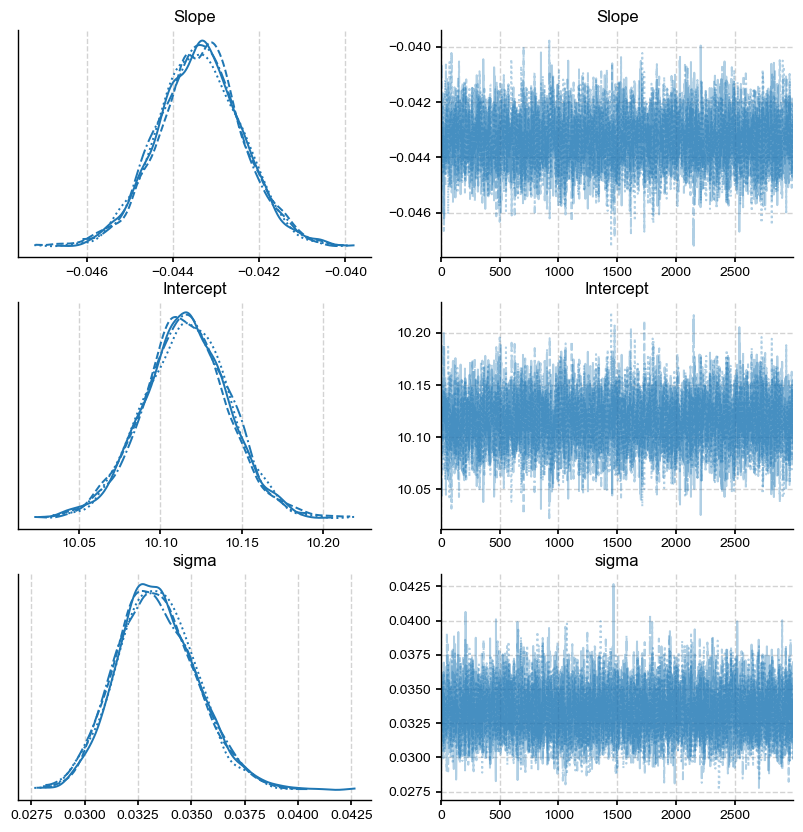

In [6]:
az.plot_trace(idata, figsize=(10,10))
plt.show()

The left panel shows the posterior distributions for the slope, intercept and the standard deviation of the regression residuals (`sigma`). Each line on this plot represents a different sampling chain, a parameter which was set to 4. For convergence, you should ensure that the 4 chains give you a similar answer. The right panel shows the 4 sampling chains for the posterior (i.e. the actual sequence of draws from the posterior). The sampling chains for the three parameters seem homogeneous and stationary (no large drifts and other noticeable patterns). This is good news, and likely means that the algorithm has likely converged towards the answer.

Now let's have a closer look at the mean of the distributions and associated standard deviations:

In [7]:
print("Slope Mean:", f"{idata.posterior['Slope'].mean():.3f}")
print("Slope Standard Deviation:", f"{idata.posterior['Slope'].std():.3f}")
print("Intercept Mean:", f"{idata.posterior['Intercept'].mean():.3f}")
print("Intercept Standard Deviation:", f"{idata.posterior['Intercept'].std():.3f}")

Slope Mean: -0.043
Slope Standard Deviation: 0.001
Intercept Mean: 10.116
Intercept Standard Deviation: 0.026


The statistics of the distribution are the same as the point estimates obtained from the linear regression [performed in the previous chapter](FrequentistCalibration.ipynb). This is to be expected. However, a big advantage of Bayesian regression is that we now have joint probability distributions for possible regression lines. Let's plot a few of them:

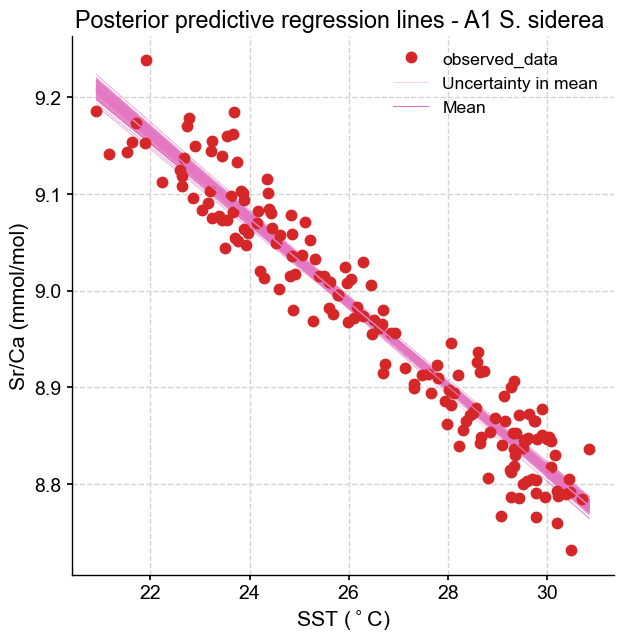

In [8]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["Slope"] * xr.DataArray(x)

_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, x=x,y_model="y_model")
ax.set_title("Posterior predictive regression lines - A1 S. siderea ")
ax.set_xlabel('SST ($^\circ$C)')
ax.set_ylabel('Sr/Ca (mmol/mol)')
plt.legend(loc='upper right');

We can see that the lines are very close to each other around the centroid of the dataset (SST near 26°C, Sr/Ca near 9 mmol/mol) but fan out near the edges of the range -- as predicted by theory. 


## *Montastraea faveolata*

Let's redo the calculation for *Montastraea faveolata* Sr/Ca using similar priors. 
### Estimating the model

For ease, let's store the data into two variables `x` and `y`. `y` contains the Sr/Ca data and `x` is the Sand Key data. 

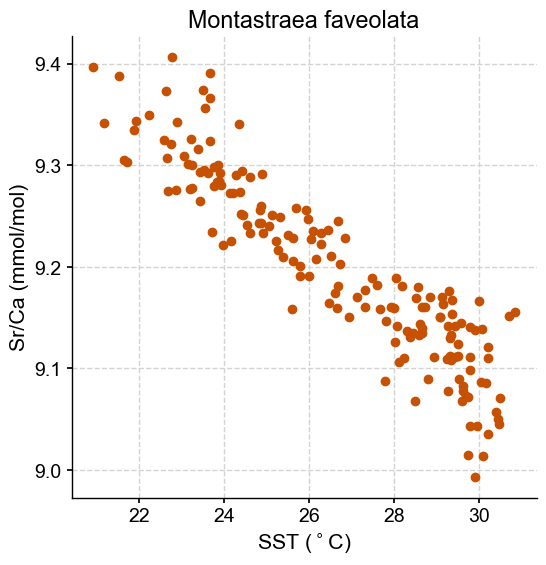

In [9]:
cleaned_df = df.dropna(subset=['Mean Sr/Ca (mmol/mol).2','Sand Key SST (ºC)']) #Remove NaNs

y = cleaned_df.iloc[:,7]
x = cleaned_df.iloc[:,12]

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(x,y,marker= 'o', color = sns.xkcd_rgb['dark orange'])
ax.set_title('Montastraea faveolata')
ax.set_xlabel('SST ($^\circ$C)')
ax.set_ylabel('Sr/Ca (mmol/mol)')
plt.show()

Let's fit our model:

In [10]:
with Model() as model:
    
    # Prior is a uniform distribution over the -1 to 0 interval for the slope and 0 to 50 for intercept
    slope = Uniform('Slope',lower=-0.1, upper=0)
    intercept = Uniform('Intercept',lower=5, upper=15)
    sigma = HalfCauchy("sigma", beta=10)
    
    #Define the likelihood 
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)
    #inference with 5000 samples, tuning on the first 1000 with 4 chains   
    idata = sample(draws=5000, chains = 4, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


### Analyzing the model

Let's plot the posterior distribution and calculate the statistis:

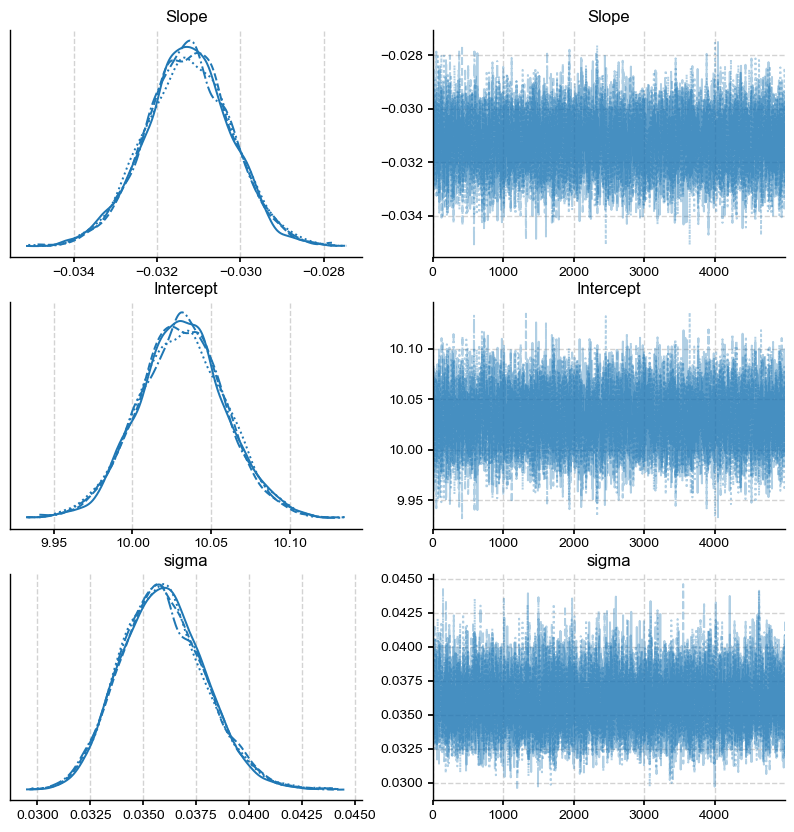

In [11]:
az.plot_trace(idata, figsize=(10,10))
plt.show()

Once again, the different lines on the posterior distributions represent the 4 sampling chains. They show similar answers, suggesting that the distribution is independent of the choice of initial condition. 

In [12]:
print("Slope Mean:", f"{idata.posterior['Slope'].mean():.3f}")
print("Slope Standard Deviation:", f"{idata.posterior['Slope'].std():.3f}")
print("Intercept Mean:", f"{idata.posterior['Intercept'].mean():.3f}")
print("Intercept Standard Deviation:", f"{idata.posterior['Intercept'].std():.3f}")

Slope Mean: -0.031
Slope Standard Deviation: 0.001
Intercept Mean: 10.031
Intercept Standard Deviation: 0.028


## Why use the Bayesian framework?

Thanks to toolboxes like [PyMC](https://www.pymc.io/welcome.html), it is now easier than ever to implement Bayesian regression. But is it truly necessary? After all, our mean and standard deviation are similar to that obtained with the [frequentist method](FrequentistCalibration.ipynb).  However, there are several advantages in using the Bayesian framework:

1. The ability to sample directly from the posterior distributions to create possible equations for the calibration, which allows for a better estimation of the uncertainty. Such an example can be  [Khider et al. (2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013PA002534).
2. Calibrating when there is not a lot of data. One of the advantages (and drawbacks) of Bayesian statistics is the encoding of prior knowledge in the form of a probability distribution. In the case of the coral calibration presented here, this prior knowledge may have come from a similar exercise performed on the same species of coral, or in a similar location.

### Estimation of uncertainty using Bayesian posteriors

As mentioned earlier, a big advantage of Bayesian regression is that we now have joint probability distributions for possible regression lines. In other words, you have possible equations for regression lines that can be applied to all points in the timeseries to get an ensemble of possible realizations of the temperature evolution. This has important implications for uncertainty quantification since the errors are now becoming dependent and therefore the uncertainty is less when making comparison within the timeseries (e.g., comparing the temperature over the 1980-2000 period with that of the 1960-1980 period) than between two timeseries. 

For this example, let's first re-run the calibration for *Siderastrea sidera* - core A1 with the most recent subset of the data (50% split), keeping the second half of the data for validation. 

In [13]:
cleaned_df = df.dropna(subset=['Mean Sr/Ca (mmol/mol)','Sand Key SST (ºC)']) #Remove NaNs
split_index = len(cleaned_df) // 2

# Split the DataFrame into two halves
df_train = cleaned_df.iloc[:split_index]

Let's re-run the calibration using the same priors:

In [14]:
y = df_train.iloc[:,1]
x = df_train.iloc[:,12]

with Model() as model:
    
    # Prior is a uniform distribution over the -1 to 0 interval for the slope and 0 to 50 for intercept
    slope = Uniform('Slope',lower=-0.1, upper=0)
    intercept = Uniform('Intercept',lower=5, upper=15)
    sigma = HalfCauchy("sigma", beta=10)
    
    #Define the likelihood 
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)
    #inference with 3000 samples, tuning on the first 1000 with 4 chains   
    idata = sample(draws=3000, chains = 4, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 8 seconds.


Let's have a look at the mean value and error on the coefficients of the equation:

In [15]:
print("Slope Mean:", f"{idata.posterior['Slope'].mean():.3f}")
print("Slope Standard Deviation:", f"{idata.posterior['Slope'].std():.3f}")
print("Intercept Mean:", f"{idata.posterior['Intercept'].mean():.3f}")
print("Intercept Standard Deviation:", f"{idata.posterior['Intercept'].std():.3f}")

Slope Mean: -0.046
Slope Standard Deviation: 0.001
Intercept Mean: 10.188
Intercept Standard Deviation: 0.035


Let's calculate SST from coral Sr/Ca and plot some traces for the entire record. Each trace represents a possible realization for the sea surface temperature evolution that takes into account the uncertainty in the calibration:

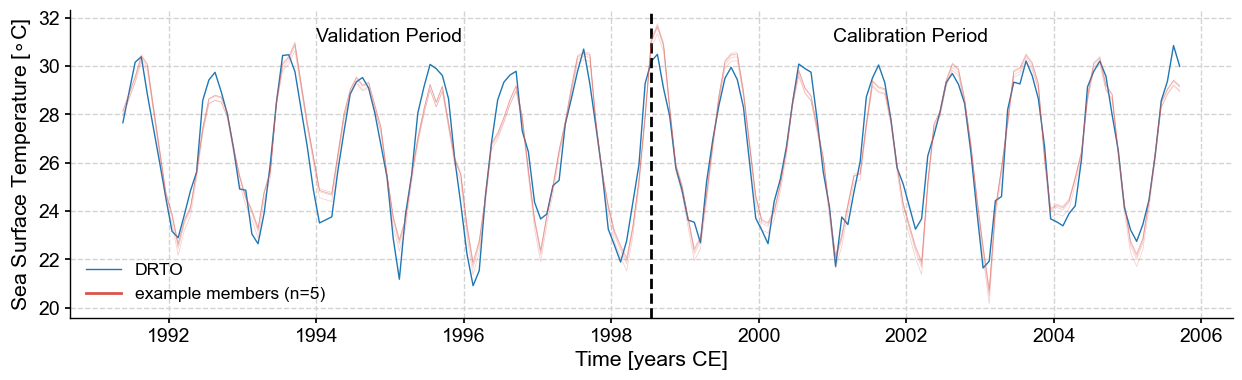

In [16]:
ser = (xr.DataArray(cleaned_df.iloc[:,1]) - idata.posterior["Intercept"])/idata.posterior["Slope"]

#create a Pyleoclim EnsembleSeries Object from the first chain
ser_list = []
for i in range(3000):
    ts =pyleo.Series(time=cleaned_df.iloc[:,0].to_numpy(), value = ser[:,0,i].to_numpy(), time_name='Year', time_unit='CE', value_name = 'Sea Surface Temperature', value_unit = '$\circ$C', verbose=False, label = 'core A1')
    ser_list.append(ts)

ens = pyleo.EnsembleSeries(ser_list)
fig,ax = plt.subplots(figsize=(15,4))
ax.plot(cleaned_df.iloc[:,0], cleaned_df.iloc[:,12], linewidth=1, label = 'DRTO')
ens.plot_traces(num_traces=5, ax=ax)
ax.axvline(x= cleaned_df.iloc[split_index,0], linestyle = '--', color = 'k')
ax.text(1994,31,'Validation Period')
ax.text(2001,31,'Calibration Period')
fig.show()

Since the signal-to-noise (uncertainty) ratio for this particular example is large, the traces are close to each other and closely match the observed sea surface temperature evolution, including for the validation period. 

Let's now apply this same calibration to another coral record from the same lcoation (Dry Tortugas) generated by [Delong et al. (2014)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013PA002524). The data for this record is available in the [LiPD format](https://lipd.net) on the [LiPDverse website](https://lipdverse.org/lipdverse/current_version/Ocn-DryTortugas.DeLong.2014.html) as part of the [PAGES2k compilation](https://www.nature.com/articles/sdata201788#citeas).

The file is provided within the GitHub repository and we will open it with the [PyLiPD package](https://pylipd.readthedocs.io/en/latest/).

In [17]:
D = LiPD()

data_path = './data/Ocn-DryTortugas.DeLong.2014.lpd'
D.load(data_path)

Loading 1 LiPD files


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 28.10it/s]

Loaded..


Let's extract the timeseries available in this dataset:

In [18]:
df = D.get_timeseries_essentials(D.get_all_dataset_names()[0])
df.head()

,dataSetName,archiveType,geo_meanLat,geo_meanLon,geo_meanElev,paleoData_variableName,paleoData_values,paleoData_units,paleoData_proxy,paleoData_proxyGeneral,time_variableName,time_values,time_units,depth_variableName,depth_values,depth_units
0,Ocn-DryTortugas.DeLong.2014,Coral,24.6,-82.3,-4.0,Sr_Ca,"[8.7956423285, 8.83055918875, 8.88449857625, 8...",mmol/mol,Sr/Ca,None,year,"[2008.625, 2008.54166666667, 2008.45833333333,...",yr AD,None,None,None


Let's calibrate the Sr/Ca record:

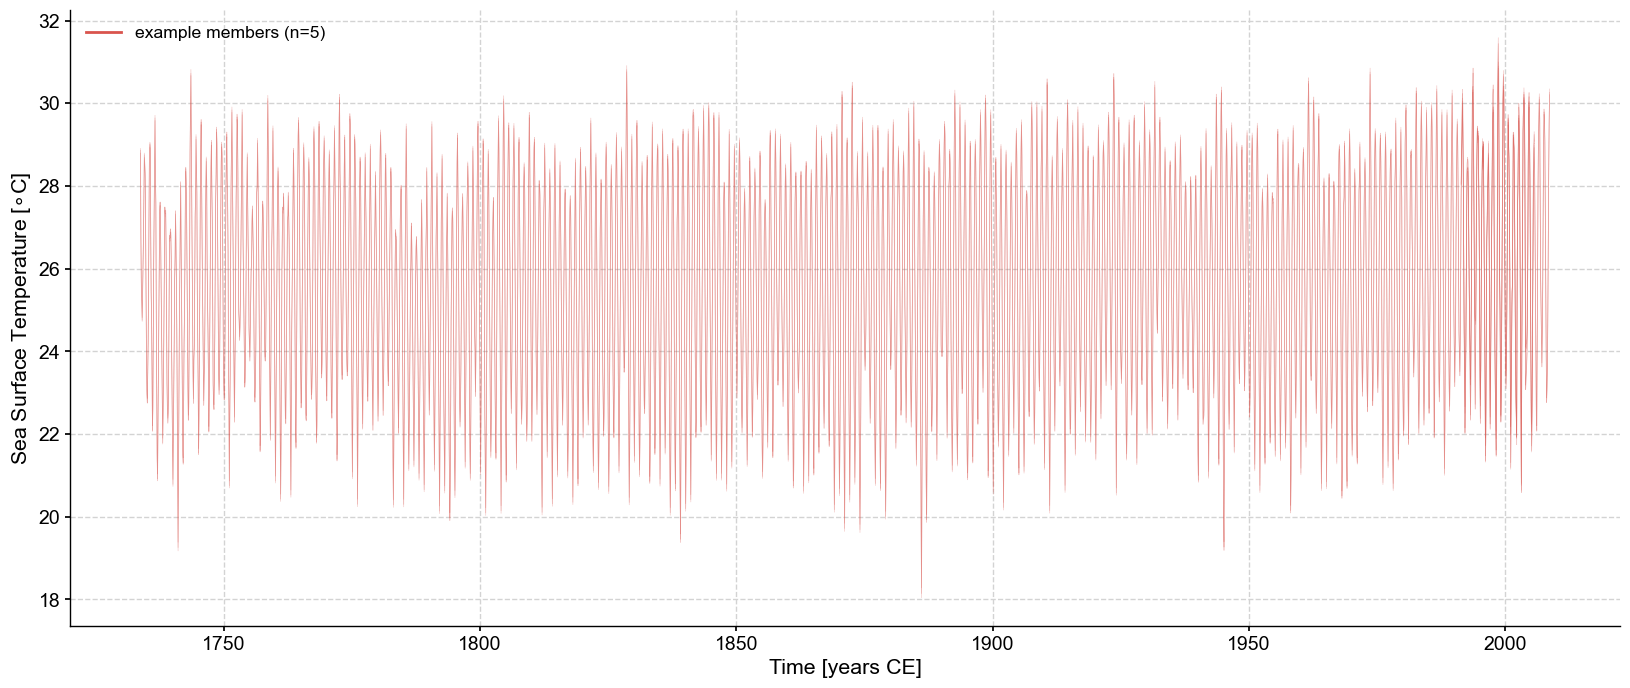

In [19]:
sst = (xr.DataArray(df['paleoData_values'].iloc[0]) - idata.posterior["Intercept"])/idata.posterior["Slope"]

#create a Pyleoclim EnsembleSeries Object from the first chain
sst_list = []
for i in range(3000):
    ts =pyleo.Series(time=df['time_values'].iloc[0], value = sst[:,0,i].to_numpy(), time_name='Year', time_unit='CE', value_name = 'Sea Surface Temperature', value_unit = '$\circ$C', verbose=False, label = 'Dry Tortugas')
    ser_list.append(ts)

ens = pyleo.EnsembleSeries(ser_list)
fig,ax = ens.plot_traces(num_traces=5, figsize=(20,8))

Since the traces are close to each other (high signal to noise ratio), let's zoom in on two years:

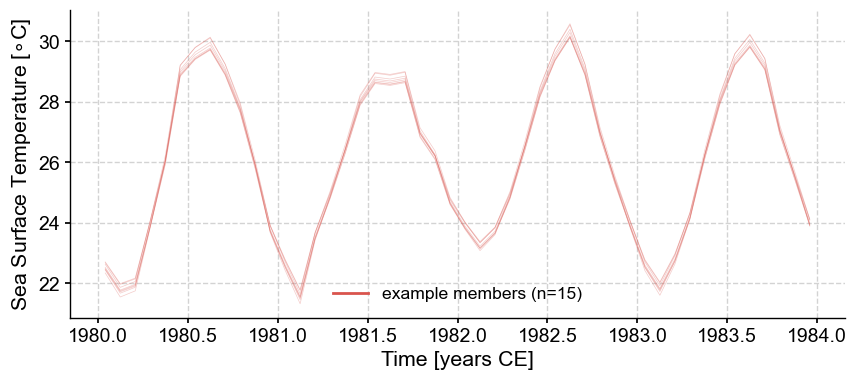

In [20]:
ens_slice = ens.slice([1980,1984])

fig,ax = ens_slice.plot_traces(num_traces=15)

You can observe slight differences in the temperature variability that is apparent at the trough and peaks. Further analyses (e.g., calculating temperature difference among time periods, establishing thresholds compared to a reference period, spectral and wavelet analyses) can be conducted on each member of the ensemble, proving more robust conclusions in relation to the uncertainty present in the record.

As an example, let's run spectral analysis on the ensemble. For pre-processing, we will interpolate the timeseries using [linear interpolation](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.interp) to put it on an even grid and standardize it. We will use the [multi-taper method (MTM](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.spectral) to compute the periodogram.

In [24]:
psd_ens = ens.interp().standardize().spectral(method='mtm')

Performing spectral analysis on individual series: 100%|█| 6000/6000 [00:05<00:0


We can plot the results as an envelope:

(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Period [years CE]', ylabel='PSD'>)

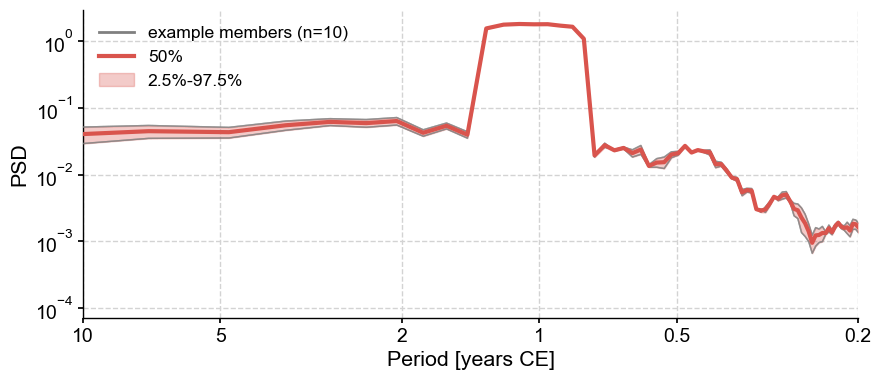

In [25]:
psd_ens.plot_envelope()

The only peak corresponds to the annual cycle.

### Bayesian pitfall: encoding priors

In a Bayesian framework, a prior is established and then refined as new evidence (i.e., data points) is incorporated, resulting in the posterior distribution. As a result, when evidence is sparse, the prior has a greater influence on the final estimates. Additionally, if the prior is overly specific, it can bias the final outcome towards that prior, even when new evidence is introduced.

Let's have a look at what happened when less data become available by randomly sampling 100%, 60%, 40%, 20% and 10% of the available data and when the prior is overly specific. For this example, we will set the prior from [Maupin et al. (2008)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008GC002106):

1. Slope - Gaussian Prior - mean = -0.039 , standard deviation = 0.005
2. Intercept - Gaussian Prior - mean = 10.008 , standard deviation = 0.13

The equation was derived from coral heads of *Siderastrea sidera* from the same Dry Tortugas location, which makes it an ideal starting point for the prior. We will compare the results of the Bayesian calibration with that of its frequentist counterpart.

In [32]:
# Re-open the calibration dataset as it has been overwrritten in the previous cell

url = 'https://www.ncei.noaa.gov/pub/data/paleo/coral/atlantic/tortugas2011.xls'
df = pd.read_excel(url, sheet_name=1,header=[2])

# grab the needed data without NaNs

cleaned_df = df.dropna(subset=['Mean Sr/Ca (mmol/mol)','Sand Key SST (ºC)']) #Remove NaNs

y = cleaned_df.iloc[:,1]
x = cleaned_df.iloc[:,12]

df_calib = pd.DataFrame({'sst':x,'SrCa':y})

# Set up the number of points for each experiment
stats = ['Frequentist','Bayesian']
opt = [1,0.6,0.4,0.2,0.1,0.05]

# Create empty lists to save the outcome
    # Frequentist
slope = []
intercept = []
slope_u = []
intercept_u = []
    #Bayesian
slope_b = []
intercept_b = []
slope_b_u = []
intercept_b_u = [] 

In [33]:
# Loop through for the calculation

for item in opt:
    sampled_df = df_calib.sample(frac=item, random_state=1)
    for stat in stats:
        if stat == 'Frequentist':
            X = sampled_df.iloc[:,0]
            Y = sampled_df.iloc[:,1]
            X = sm.add_constant(X)
            ols = sm.OLS(Y,X)
            results = ols.fit()
            #get the parameters
            i, s = results.params
            #get the standard error
            i_se, s_se = results.bse
            # save to the lists
            slope.append(s)
            intercept.append(i)
            slope_u.append(s_se)
            intercept_u.append(i_se)
        elif stat == 'Bayesian':
            y = sampled_df.iloc[:,1]
            x = sampled_df.iloc[:,0]
            with Model() as model:
    
                # Prior is a uniform distribution over the -1 to 0 interval for the slope and 0 to 50 for intercept
                slope_p = Normal('Slope',-0.05, sigma=0.015)
                intercept_p = Normal('Intercept',10, sigma=0.15)
                sigma = HalfCauchy("sigma", beta=10)
    
                #Define the likelihood 
                likelihood = Normal("y", mu=intercept_p + slope_p * x, sigma=sigma, observed=y)
                #inference with 5000 samples, tuning on the first 1000 with 4 chains   
                idata = sample(draws=5000, chains = 4, tune = 1000)
                # save to the lists
                slope_b.append(idata.posterior['Slope'].mean().item())
                intercept_b.append(idata.posterior['Intercept'].mean().item())
                slope_b_u.append(idata.posterior['Slope'].std().item())
                intercept_b_u.append(idata.posterior['Intercept'].std().item())
        else:
            raise ValueError('Not an appropriate statistical method')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 7 seconds.
There were 751 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
There were 305 divergences after tuning. Increase `target_accept` or reparameterize.


Notice that the model has a hard time to converge (as seen in the number of divergences) as the number of samples diminishes, suggesting that the priors may be too specific. This should be your first clue to change the priors. 

In [36]:
import math

# Calculate the number of observations in each trial
obs = [math.ceil(i*df_calib.shape[0]) for i in opt]

# Create a list of string that gives the value of the coefficient and associated error 
freq_slope = [f"{s:.3f} +/- {u:.3f}" for s, u in zip(slope, slope_u)]
freq_intercept = [f"{s:.3f} +/- {u:.3f}" for s, u in zip(intercept, intercept_u)]
bay_slope = [f"{s:.3f} +/- {u:.3f}" for s, u in zip(slope_b, slope_b_u)]
bay_intercept = [f"{s:.3f} +/- {u:.3f}" for s, u in zip(intercept_b, intercept_b_u)]

# Make a dataframe to use with great tables

df_res = pd.DataFrame({'Number of points':obs,
                       'fs': freq_slope,
                       'fi': freq_intercept,
                       'bs': bay_slope,
                       'bi': bay_intercept,
                      })

In [37]:
gt_tbl_wls = (GT(df_res)
          .tab_spanner(label=md("Frequentist Approach"), columns=["fs", "fi"]) 
          .tab_spanner(label=md("Bayesian Approach"), columns=["bs", "bi"])
          .cols_label(fs="Slope", fi="Intercept", bs="Slope", bi="Intercept")    
          .tab_header(title=html('Calibration of <em>Siderastrea sidera</em> Sr/Ca to SST, frequentist vs Bayesian approach'))
          .tab_options(column_labels_background_color="darkgrey",source_notes_background_color="OldLace")
         )  
gt_tbl_wls

GT(_tbl_data=   Number of points                fs                fi                bs  \
0               168  -0.043 +/- 0.001  10.115 +/- 0.025  -0.043 +/- 0.001   
1               101  -0.043 +/- 0.001  10.099 +/- 0.032  -0.043 +/- 0.001   
2                68  -0.041 +/- 0.001  10.059 +/- 0.038  -0.041 +/- 0.001   
3                34  -0.045 +/- 0.002  10.163 +/- 0.060  -0.044 +/- 0.002   
4                17  -0.048 +/- 0.003  10.240 +/- 0.069  -0.046 +/- 0.003   
5                 9  -0.044 +/- 0.003  10.110 +/- 0.077  -0.043 +/- 0.003   

                 bi  
0  10.113 +/- 0.025  
1  10.095 +/- 0.031  
2  10.058 +/- 0.038  
3  10.144 +/- 0.058  
4  10.195 +/- 0.070  
5  10.086 +/- 0.079  , _body=<great_tables._gt_data.Body object at 0x3862ef8d0>, _boxhead=Boxhead([ColInfo(var='Number of points', type=<ColInfoTypeEnum.default: 1>, column_label='Number of points', column_align='right', column_width=None), ColInfo(var='fs', type=<ColInfoTypeEnum.default: 1>, column_label='Slope', column_align='right', column_width=None), ColInfo(var='fi', type=<ColInfoTypeEnum.default: 1>, column_label='Intercept', column_align='right', column_width=None), ColInfo(var='bs', type=<ColInfoTypeEnum.default: 1>, column_label='Slope', column_align='right', column_width=None), ColInfo(var='bi', type=<ColInfoTypeEnum.default: 1>, column_label='Intercept', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x37a557810>, _spanners=Spanners([SpannerInfo(spanner_id='Frequentist Approach', spanner_level=0, spanner_label=Md(text='Frequentist Approach'), spanner_units=None, spanner_pattern=None, vars=['fs', 'fi'], built=None), SpannerInfo(spanner_id='Bayesian Approach', spanner_level=0, spanner_label=Md(text='Bayesian Approach'), spanner_units=None, spanner_pattern=None, vars=['bs', 'bi'], built=None)]), _heading=Heading(title=Html(text='Calibration of <em>Siderastrea sidera</em> Sr/Ca to SST, frequentist vs Bayesian approach'), subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x393329d50>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='v

The Bayesian and frequentist approaches give very similar results despite the divergences. As the number of samples decreases, the Bayesian approach stays slightly closer to the prior values. 

## References

DeLong, K.L., J.A. Flannery, C.R. Maupin, R.Z. Poore, and T.M. Quinn. 2011. A coral Sr/Ca calibration and replication study of two massive corals from the Gulf of Mexico. Palaeogeography, Palaeoclimatology, Palaeoecology, 307(1-4), 117-128. doi: 10.1016/j.palaeo.2011.05.005

DeLong, K. L., J. A. Flannery, R. Z. Poore, T. M. Quinn, C. R. Maupin, K. Lin, and C.-C. Shen (2014), A reconstruction of sea surface temperature variability in the southeastern Gulf of Mexico from 1734 to 2008 C.E. using cross-dated Sr/Ca records from the coral Siderastrea siderea, Paleoceanography, 29, 403–422, doi:10.1002/2013PA002524.

Khider, D., C. S. Jackson, and L. D. Stott (2014), Assessing millennial-scale variability during the Holocene: A perspective from the western tropical Pacific, Paleoceanography, 29, 143–159, doi:10.1002/2013PA002534.

Maupin, C. R., T. M. Quinn, and R. B. Halley (2008), Extracting a climate signal from the skeletal geochemistry of the Caribbean coral Siderastrea siderea, Geochem. Geophys. Geosyst., 9, Q12012, doi:10.1029/2008GC002106.

PAGES2k Consortium. A global multiproxy database for temperature reconstructions of the Common Era. Sci Data 4, 170088 (2017). https://doi.org/10.1038/sdata.2017.88